In [1]:
from sklearn.datasets import load_svmlight_file

train_path = "/kaggle/input/optimization-a9a/a9a.txt"
test_path  = "/kaggle/input/optimization-a9a/a9a_test.txt"

# load data
X_train, y_train = load_svmlight_file(train_path)
X_test,  y_test  = load_svmlight_file(test_path, n_features=X_train.shape[1])

# keep original ±1 labels for nonconvex use
y_orig_train = y_train.copy()
y_orig_test  = y_test.copy()

# convert to {0,1} for cross-entropy
y_train = (y_train + 1) // 2
y_test  = (y_test  + 1) // 2

# y_orig_train / y_orig_test
ypm_train = y_orig_train.copy()
ypm_test  = y_orig_test.copy()

print("Cell 1 complete: data loaded")
print("  X_train.shape =", X_train.shape)
print("  X_test.shape  =", X_test.shape)


Cell 1 complete: data loaded
  X_train.shape = (32561, 123)
  X_test.shape  = (16281, 123)


In [2]:
import numpy as np
import time



EPOCHS = 1
ITER_PER_EPOCH = X_train.shape[1]
MAX_ITER = EPOCHS * ITER_PER_EPOCH

print(f"Feature dim (d)     : {ITER_PER_EPOCH}")
print(f"Epochs              : {EPOCHS}")
print(f"Total max_iter      : {MAX_ITER}")

lambda_reg = 1e-4

def logistic_loss(X, y, w, lambda_reg=lambda_reg): 
    """
    Compute logistic regression loss with L2 regularization:
        f(w) = (1/n) * Σ log(1 + exp(-y_i * x_i^T w)) + (λ/2) * ||w||^2
    This loss is smooth and becomes λ-strongly convex when λ > 0.
    """
    n_samples = X.shape[0]
    z = X @ w
    probs = 1 / (1 + np.exp(-z))
    data_loss = -np.mean(y * np.log(probs + 1e-12)
                         + (1 - y) * np.log(1 - probs + 1e-12))
    reg = 0.5 * lambda_reg * np.dot(w, w)
    return data_loss + reg  

def logistic_full_grad(X, y, w, lambda_reg=lambda_reg):
    """
    Full gradient of logistic + L2:
        ∇f = (1/n) Xᵀ(σ(Xw) - y) + λ w
    """
    n_samples = X.shape[0]
    z = X @ w
    probs = 1 / (1 + np.exp(-z))
    grad_data = X.T @ (probs - y) / n_samples
    return grad_data + lambda_reg * w


def logistic_grad_i(X, y, w, i, lambda_reg=lambda_reg):
    """
    Coordinate i partial derivative of logistic + L2:
        ∂f/∂w_i = (1/n) Σ_j x_{j,i} (σ(x_j·w)-y_j) + λ w_i
    """
    n_samples = X.shape[0]
    z = X @ w
    probs = 1 / (1 + np.exp(-z))
    grad_i = X[:, i].T @ (probs - y) / n_samples
    return grad_i + lambda_reg * w[i]

def compute_accuracy(X, y, w):
    """
    Compute classification accuracy for logistic model:
      predict = 1{σ(Xw) ≥ 0.5}
    """
    probs = 1 / (1 + np.exp(-X @ w))
    preds = (probs >= 0.5).astype(int)
    return np.mean(preds == y)


def compute_Ls(X, lambda_reg=lambda_reg):
    """
    Estimate per-coordinate Lipschitz constants for logistic loss + L2:
        L_i ≈ (||X[:, i]||^2) / (4 * n_samples) + λ
    Supports both dense arrays and CSR sparse matrices.
    """
    n_samples = X.shape[0]
    # element-wise square and sum over samples
    if hasattr(X, "multiply"):
        # for CSR matrix, use multiply for element-wise square
        squared_sums = np.asarray(X.multiply(X).sum(axis=0)).ravel()
    else:
        # for dense array
        squared_sums = np.sum(X**2, axis=0)
    base_L = squared_sums / (4 * n_samples)
    return base_L + lambda_reg


def timed_gradient_descent(*args, **kwargs):
    t0 = time.time()
    w, obj_values = gradient_descent(*args, **kwargs)
    return w, obj_values, time.time() - t0
    
def timed_rcd_single(X, y, loss_grad_i, Ls, alpha, **kwargs):
    t0 = time.time()
    w, obj_values = randomized_coordinate_descent(
        X, y, loss_grad_i, Ls, alpha=alpha, **kwargs
    )
    return w, obj_values, time.time() - t0
    
def timed_rcd(X, y, loss_grad_i, Ls, alphas, **kwargs):
    times = {}
    histories = {}
    for alpha in alphas:
        t0 = time.time()
        _, obj_values = randomized_coordinate_descent(
            X, y, loss_grad_i, Ls, alpha=alpha, **kwargs)
        histories[alpha] = obj_values
        times[alpha] = time.time() - t0
    return histories, times

def timed_acd(*args, **kwargs):
    t0 = time.time()
    w, obj_values, _ = acd(*args, **kwargs)
    return w, obj_values, time.time() - t0


def gradient_descent(X, y, loss_full_grad, loss_fn, L,
                     max_iter=MAX_ITER, x0=None):
    """
    Full gradient descent with fixed step size 1/L.
    Returns final x and loss history.
    """
    n_samples, n_features = X.shape
    x = np.zeros(n_features) if x0 is None else x0.copy()
    obj_values = []
    for _ in range(max_iter):
        grad = loss_full_grad(X, y, x)
        x -= grad / L
        obj_values.append(loss_fn(X, y, x))
    return x, obj_values

# Randomized Coordinate Descent (RCD)
def randomized_coordinate_descent(X, y, loss_grad_i, Ls,
                                  alpha=1.0, loss_fn=logistic_loss,
                                  max_iter=MAX_ITER, x0=None):
    obj_values = [] 
    n_samples, n_features = X.shape
    x = np.zeros(n_features) if x0 is None else x0.copy()
    weights = Ls**alpha
    p = weights / weights.sum()
    for _ in range(max_iter):
        i = np.random.choice(n_features, p=p)
        gi = loss_grad_i(X, y, x, i)
        x[i] -= gi / Ls[i]
        obj_values.append(loss_fn(X, y, x))
    return x, obj_values



# Randomized Coordinate Descent (RCD)

def run_rcd_for_multiple_alphas(X, y, loss_grad_i, Ls,
                                alphas=(0.0, 0.5, 1.0),
                                loss_fn=logistic_loss,
                                max_iter=MAX_ITER, x0=None):
    """
    Run RCD for each alpha in `alphas` and collect history.
    Returns a dict mapping alpha -> list of loss values per iteration.
    """
    histories = {}
    for alpha in alphas:
        _, obj_values = randomized_coordinate_descent(
            X, y, loss_grad_i, Ls,
            alpha=alpha, loss_fn=loss_fn,
            max_iter=MAX_ITER, x0=x0
        )
        histories[alpha] = obj_values
    return histories


def acd(X, y, num_iters=MAX_ITER, lambda_reg=lambda_reg,sigma=None, Li=None, loss_fn=logistic_loss):
    n, d = X.shape
    if sigma is None:
        sigma = lambda_reg
    if Li    is None: 
        Li    = compute_Ls(X, lambda_reg)

    x = np.zeros(d)
    v = np.zeros(d)
    a = 0.5
    b = 1.0

    obj_values = []
    x_history  = []
    
    for it in range(num_iters):
        # (1) compute gamma from old a,b
        B     = (sigma/d)*(a**2/b**2) - 1.0/d
        C     = -(a**2/b**2)
        gamma = (-B + np.sqrt(B*B - 4*C)) / 2
    
        # (2) compute beta
        beta  = 1 - gamma*sigma/d
    
        # (3) compute alpha and yk using old x,v
        alpha = (d - gamma*sigma) / (gamma*(d*d - sigma))
        yk    = alpha*v + (1-alpha)*x
    
        # (4) coordinate update to get new x,v
        i      = np.random.randint(d)
        gi     = logistic_grad_i(X, y, yk, i, lambda_reg)
        x_new  = yk.copy();   x_new[i] -= gi / Li[i]
        v_new  = beta*v + (1-beta)*yk
        v_new[i] -= (gamma / Li[i]) * gi
    
        # (5) now update b,a using beta_k
        b      = b / np.sqrt(beta)
        a      = gamma * b
    
        # (6) commit x,v and record loss
        x, v   = x_new, v_new
        obj_values.append(loss_fn(X, y, x))
        x_history.append(x.copy())

    return x, obj_values, x_history

def nonconvex_regularizer(w, lambda_, alpha):
    return lambda_ * np.sum((alpha * w**2) / (1 + alpha * w**2))

def logistic_loss_nonconvex(X, y, w, lambda_=0.001, alpha=1.0):
    n_samples = X.shape[0]
    z = X @ w
    probs = 1 / (1 + np.exp(-z))
    data_loss = -np.mean(y * np.log(probs + 1e-12) + (1 - y) * np.log(1 - probs + 1e-12))
    reg = nonconvex_regularizer(w, lambda_, alpha)
    return data_loss + reg

def logistic_grad_i_nonconvex(X, y, w, i, lambda_=0.001, alpha=1.0):
    n_samples = X.shape[0]
    z = X @ w
    probs = 1 / (1 + np.exp(-z))
    grad_i = X[:, i].T @ (probs - y) / n_samples
    reg_grad_i = 2 * lambda_ * alpha * w[i] / (1 + alpha * w[i]**2)**2
    return grad_i + reg_grad_i
    
def logistic_full_grad_nonconvex(X, y, w, lambda_=0.001, alpha=1.0):
    """
    Full gradient of logistic loss + nonconvex regularizer:
      ∇f_data = (1/n) X^T (σ(Xw) − y)
      ∇f_reg  = 2 λ α w / (1 + α w^2)^2
    Returns ∇f = ∇f_data + ∇f_reg
    """
    n = X.shape[0]
    # Data term gradient
    z         = X @ w
    probs     = 1 / (1 + np.exp(-z))
    grad_data = X.T @ (probs - y) / n

    # Nonconvex regularizer gradient
    reg_grad  = 2 * lambda_ * alpha * w / (1 + alpha * w**2)**2

    return grad_data + reg_grad

print("Cell 2 complete: all functions loaded")


Feature dim (d)     : 123
Epochs              : 1
Total max_iter      : 123
Cell 2 complete: all functions loaded


/tmp/ipykernel_36/2849325613.py:138: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x[i] -= gi / Ls[i]


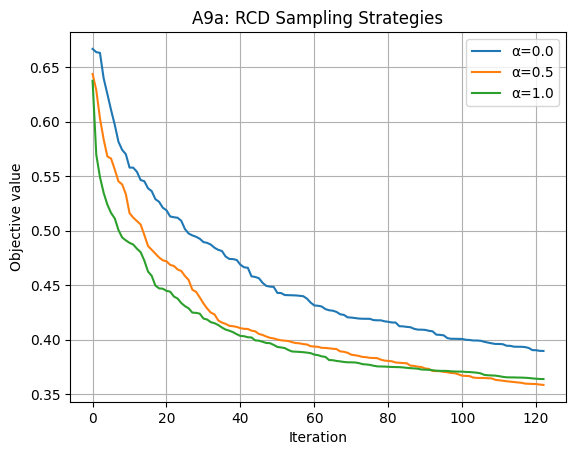

/tmp/ipykernel_36/2849325613.py:196: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_new  = yk.copy();   x_new[i] -= gi / Li[i]
/tmp/ipykernel_36/2849325613.py:198: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  v_new[i] -= (gamma / Li[i]) * gi


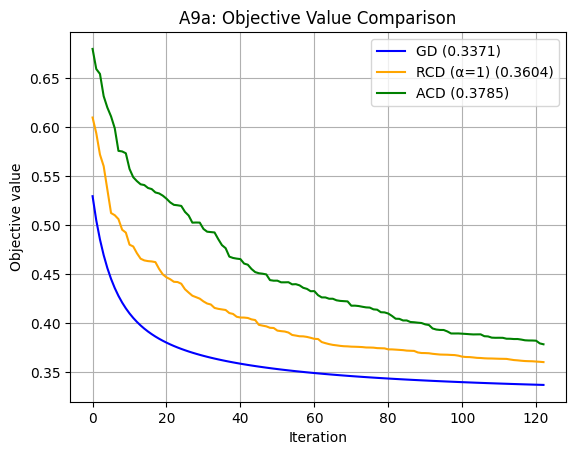

/tmp/ipykernel_36/4139476070.py:122: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  w_rcd[i] -= g / float(Ls[i])


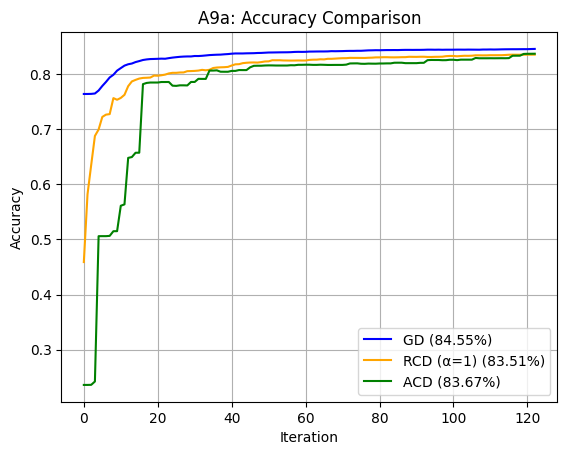

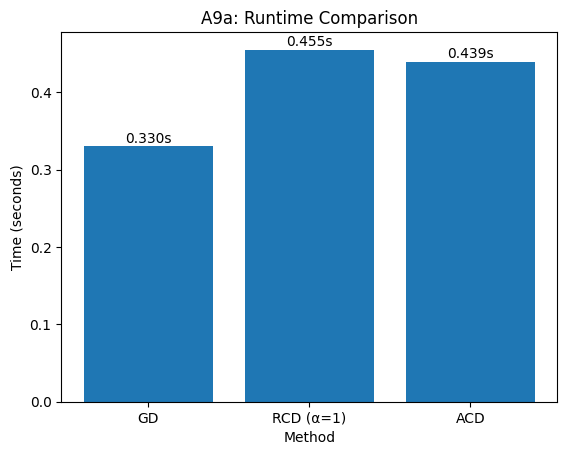

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.sparse.linalg import svds


num_runs = 5
max_iter = 123
alphas   = [0.0, 0.5, 1.0]

lambda_reg = 1e-4
Ls  = compute_Ls(X_train, lambda_reg=lambda_reg)


# 1A: RCD Sampling Strategies (average over runs)
plt.figure()
for alpha in alphas:
    all_runs = []
    for _ in range(num_runs):
        _, vals = randomized_coordinate_descent(
            X_train, y_train, logistic_grad_i, Ls,
            alpha=alpha, max_iter=max_iter
        )
        all_runs.append(vals)
    all_runs = np.array(all_runs)
    mean_vals = all_runs.mean(axis=0)
    plt.plot(mean_vals, label=f"α={alpha}")
    

plt.xlabel("Iteration")
plt.ylabel("Objective value")
plt.title("A9a: RCD Sampling Strategies")
plt.legend()
plt.grid(True)
plt.savefig("a9a_1a_rcd_sampling.png", dpi=300, bbox_inches='tight')
plt.show()

# 2A: Objective Value Comparison (average over runs)
from scipy.sparse.linalg import svds

# Estimate full-gradient Lipschitz constant
u, s, vt = svds(X_train, k=1)
sigma_max = s[0]
n_samples = X_train.shape[0]
lambda_reg = 1e-4
L_full = 0.25 * (sigma_max**2 / n_samples) + lambda_reg

gd_vals = []
rcd_vals = []
acd_vals = []

for _ in range(num_runs):
    # GD trajectory (loss history)
    _, gd_obj = gradient_descent(
        X_train, y_train,
        logistic_full_grad, logistic_loss,
        L_full, max_iter=max_iter
    )

    # RCD trajectory
    _, rcd_obj = randomized_coordinate_descent(
        X_train, y_train,
        logistic_grad_i, Ls,
        alpha=1.0, max_iter=max_iter
    )

    # ACD trajectory (we assume acd now returns x, obj_values, x_history)
    _, acd_obj, _ = acd(
        X_train, y_train,
        num_iters=max_iter,
        lambda_reg=lambda_reg,
        sigma=None,    # use default
        Li=Ls,
        loss_fn=logistic_loss
    )

    gd_vals.append(gd_obj)
    rcd_vals.append(rcd_obj)
    acd_vals.append(acd_obj)

# Stack into numeric arrays
gd_vals  = np.vstack(gd_vals)   # shape (num_runs, max_iter)
rcd_vals = np.vstack(rcd_vals)
acd_vals = np.vstack(acd_vals)

plt.figure()
for vals, name, color in zip(
    [gd_vals, rcd_vals, acd_vals],
    ["GD", "RCD (α=1)", "ACD"],
    ['blue','orange','green']
):
    mean = vals.mean(axis=0)
    last = float(mean[-1])   
    plt.plot(mean, label=f"{name} ({last:.4f})", color=color)

plt.xlabel("Iteration")
plt.ylabel("Objective value")
plt.title("A9a: Objective Value Comparison")
plt.legend()
plt.grid(True)
plt.savefig("a9a_2a_objective_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

# 3A: Accuracy vs Iteration (average over runs)
acc_gd_all  = []
acc_rcd_all = []
acc_acd_all = []

for _ in range(num_runs):
    acc_gd = []
    for t in range(1, max_iter+1):
        w_t, _ = gradient_descent(X_train, y_train, logistic_full_grad, logistic_loss, L_full, max_iter=t)
        acc_gd.append(compute_accuracy(X_test, y_test, w_t))
    acc_gd_all.append(acc_gd)

    acc_rcd = []
    w_rcd = np.zeros(X_train.shape[1])
    p = (Ls**1.0) / (Ls**1.0).sum()
    for _ in range(max_iter):
        i = np.random.choice(len(w_rcd), p=p)
        g = logistic_grad_i(X_train, y_train, w_rcd, i)
        w_rcd[i] -= g / float(Ls[i])
        acc_rcd.append(compute_accuracy(X_test, y_test, w_rcd))
    acc_rcd_all.append(acc_rcd)
    
    _, _, acd_hist = acd(
    X_train, y_train,
    num_iters = max_iter,
    lambda_reg= 1e-4,
    sigma     = None,
    Li        = Ls,
    loss_fn   = logistic_loss
)
acc_acd = [compute_accuracy(X_test, y_test, w) for w in acd_hist]
acc_acd_all.append(acc_acd)

acc_gd_all  = np.array(acc_gd_all)
acc_rcd_all = np.array(acc_rcd_all)
acc_acd_all = np.array(acc_acd_all)

plt.figure()
for acc_vals, name, color in zip([acc_gd_all, acc_rcd_all, acc_acd_all], ["GD", "RCD (α=1)", "ACD"], ['blue', 'orange', 'green']):
    mean = acc_vals.mean(axis=0)
    plt.plot(mean, label=f"{name} ({mean[-1]*100:.2f}%)", color=color)
    

plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.title("A9a: Accuracy Comparison")
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig("a9a_3a_accuracy_vs_iteration.png", dpi=300, bbox_inches='tight')
plt.show()

# 4A: Runtime Comparison (average over runs)
times = {"GD": [], "RCD (α=1)": [], "ACD": []}
for _ in range(num_runs):
    start = time.time()
    gradient_descent(X_train, y_train, logistic_full_grad, logistic_loss, L_full, max_iter=max_iter)
    times["GD"].append(time.time() - start)

    start = time.time()
    randomized_coordinate_descent(X_train, y_train, logistic_grad_i, Ls, alpha=1.0, max_iter=max_iter)
    times["RCD (α=1)"].append(time.time() - start)

    start = time.time()
    acd(X_train, y_train, num_iters=max_iter, Li=Ls)
    times["ACD"].append(time.time() - start)

plt.figure()
methods = list(times.keys())
mean_times = [np.mean(times[m]) for m in methods]


bars = plt.bar(methods, mean_times)
plt.xlabel("Method")
plt.ylabel("Time (seconds)")
plt.title("A9a: Runtime Comparison")

for bar, t in zip(bars, mean_times):
    plt.text(bar.get_x() + bar.get_width()/2,
             t + 0.001,   
             f"{t:.3f}s", ha="center", va="bottom")

plt.savefig("a9a_4a_runtime_comparison.png", dpi=300, bbox_inches='tight')
plt.show()
